In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
print(f"Old working dir {os.getcwd()}")
os.chdir('../')
print(f"New working dir {os.getcwd()}")

Old working dir /home/alex/repos/conditional_quantile_function/poc
New working dir /home/alex/repos/conditional_quantile_function


In [9]:
import numpy as np
from scipy.stats import norm, multivariate_normal
import torch
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [5]:
from conformal.real_datasets.reproducible_split import get_dataset_split
from conformal.classes.method_desc import ConformalMethodDescription
from conformal.score_calculators import CVQRegressor, CVQRegressorRF, CVQRegressorY, CVQRegressorYRF

In [5]:
alpha = 0.3
scale = 0.1
n = 10000
rng = np.random.default_rng(31337)
x = np.linspace(0, 1, n)
y_true =  x ** 1.6
y = y_true + rng.normal(scale=scale, size=n)
interval_1a = norm.interval(1 - alpha, loc=0, scale=scale)

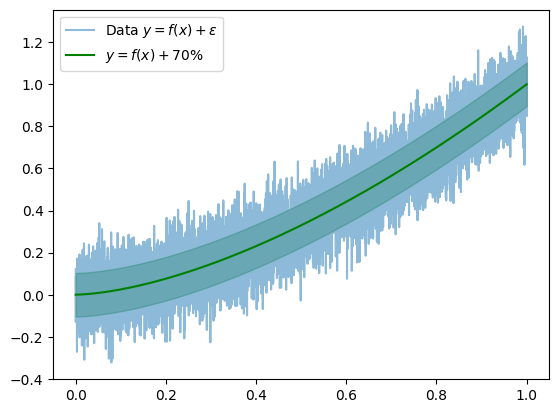

In [6]:
plt.plot(x, y, label=r"Data $y=f(x)+\epsilon$", alpha=0.5)
plt.plot(x, y_true, "g", label=rf'$y=f(x) + {int((1 - alpha) * 100)}\%$')
plt.fill_between(x, y_true + interval_1a[0], y_true + interval_1a[1], color="g", alpha=0.3)
#plt.plot(x, x, "k--", label=r'$y=x$')
plt.legend()

In [7]:
reg = CVQRegressor(
    feature_dimension=1,
    response_dimension=1,
    hidden_dimension=8,
    number_of_hidden_layers=4,
    batch_size=512,
    n_epochs=150,
    learning_rate=0.01,
    dtype=torch.float32,
    betas=(0.5, 0.5),
    weight_decay=1e-4,
    warmup_iterations=5
)
fn_model = "cvqregressor_for_1d_check_hpd3.pth"

In [8]:
if os.path.isfile(fn_model):
    reg.model.load(fn_model)
else:
    reg.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    reg.model.eval()
    reg.model.save(fn_model)

In [9]:
#reg.model.eval()

In [10]:
y_pred = reg.predict_mean(x.reshape(-1, 1))
interval_99 = norm.interval(1 - alpha, loc=0, scale=1)
y_pred_low = reg.predict_inverse_quantile(x.reshape(-1, 1), np.repeat(interval_99[0], repeats=n, axis=0).reshape(-1, 1))
y_pred_high = reg.predict_inverse_quantile(x.reshape(-1, 1), np.repeat(interval_99[1], repeats=n, axis=0).reshape(-1, 1))

In [11]:
y_pred_low.shape, y_pred_high.shape

((10000, 1), (10000, 1))

In [12]:
y_pred_low[:5]

array([[-0.12724185],
       [-0.12719268],
       [-0.12714338],
       [-0.12709403],
       [-0.12704486]], dtype=float32)

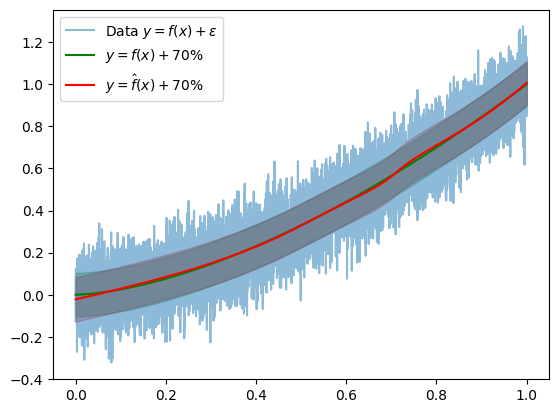

In [13]:
plt.plot(x, y, label=r"Data $y=f(x)+\epsilon$", alpha=0.5)
plt.plot(x, y_true, "g", label=rf'$y=f(x) + {int((1 - alpha) * 100)}\%$')
plt.plot(x, y_pred, "r", label=rf'$y=\hat{{f}}(x) + {int((1 - alpha) * 100)}\%$')
plt.fill_between(x, y_true + interval_1a[0], y_true + interval_1a[1], color="g", alpha=0.3)
plt.fill_between(x, y_pred_low[:, 0], y_pred_high[:, 0], color="r", alpha=0.3)
#plt.plot(x, x, "k--", label=r'$y=x$')
plt.legend()

In [14]:
quantiles = reg.predict_quantile(x.reshape(-1, 1), y.reshape(-1, 1))

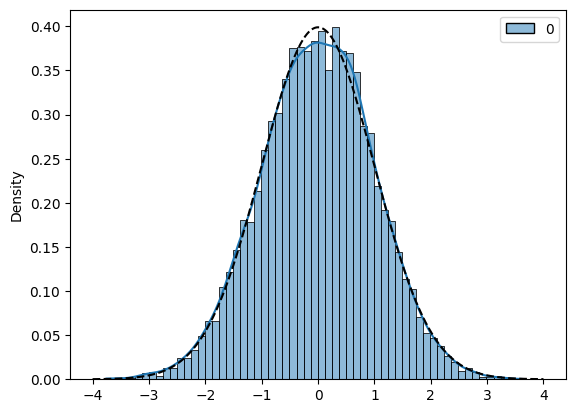

In [15]:
t = np.linspace(-4, 4, 1000)
sns.histplot(quantiles, kde=True, stat="density")
plt.plot(t, norm.pdf(t), "k--")

In [ ]:
# Look at log density at the point x = 0.5
x0 = 0.9 * np.ones((1000, 1))
#u_sample = rng.random.normal(size=1000)
scores_smaples = reg.calculate_scores(x0.reshape(-1, 1), t.reshape(-1, 1))

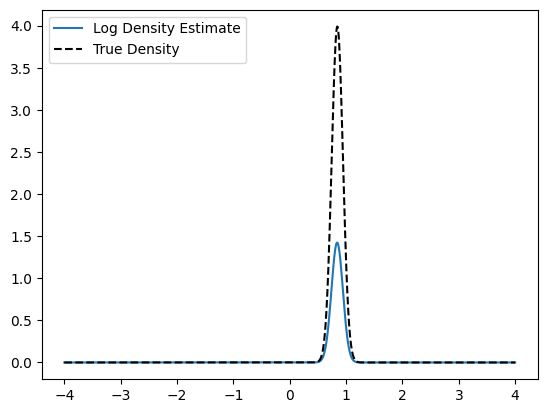

In [ ]:
plt.plot(t, np.exp(scores_smaples["Log Density"]), label="Log Density Estimate") #scores["Log Density"]
plt.plot(t, norm.pdf(t, loc=x0[0]**1.6, scale=scale), "k--", label="True Density")
plt.legend()
plt.show()

In [1]:
import os
os.chdir('/home/alex/repos/conditional_quantile_function')

from argparse import Namespace
from pathlib import Path

import numpy as np
from scipy.stats import norm, multivariate_normal
import torch
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pushforward_operators import AmortizedNeuralQuantileRegression
from conformal.real_datasets.reproducible_split import get_dataset_split
from conformal.score_calculators import CVQRegressorRF, CVQRegressorY, CVQRegressor, CPFlowRegressor
from conformal.classes.conformalizers import QuantileEstimatePredictor, SplitConformalPredictor


In [2]:
ds_sgemm_a = get_dataset_split("rf1", seed=1239)
ds_sgemm_b = get_dataset_split("rf1", seed=1239)

Reducing 64 features  to 50 with PCA
Reducing 64 features  to 50 with PCA


In [3]:
ds_sgemm_a.X_cal[0, 0], ds_sgemm_b.X_cal[0, 0]

(np.float64(-0.30384420792278083), np.float64(-0.30384420792278083))

In [20]:
#Multiple dimensions

seed = 0
dataset = "scm20d"
ds = get_dataset_split(dataset, seed=seed)
args = Namespace(
    dataset=dataset,
    seed=seed,
    n_cpus=8,
)

#model_cpflow = CPFlowRegressor.create_or_load(
#    path=Path(f"./conformal_results_u/{dataset}/{seed}"), args=args, dataset_split=ds
#)
#model_cpflow.model.eval()

model_u = CVQRegressor.create_or_load(
    path=Path(f"./conformal_results_u/{dataset}/{seed}"), args=args, dataset_split=ds
)
model_u.model.eval()
#model_y = CVQRegressorY.create_or_load(
#    path=Path(f"./conformal_results_u/{dataset}/{seed}"), args=args, dataset_split=ds
#)
#model_y.model.eval()


Reducing 61 features  to 50 with PCA
save_path=PosixPath('conformal_results_u/scm20d/0/model_CVQRegressor.pth')
self.potential_to_estimate_with_neural_network='u'


AmortizedNeuralQuantileRegression(
  (potential_network): PISCNN(
    (z_activation): Softplus(beta=1.0, threshold=20.0)
    (u_activation): ELU(alpha=1.0)
    (positive_activation): Softplus(beta=1.0, threshold=20.0)
    (first_linear_layer_tilde): Linear(in_features=50, out_features=10, bias=True)
    (first_linear_layer_uy): Linear(in_features=50, out_features=16, bias=True)
    (first_linear_layer_y): Linear(in_features=16, out_features=10, bias=False)
    (first_linear_layer_u): Linear(in_features=50, out_features=10, bias=False)
    (first_layer_z_activation_normalization): ActNorm()
    (linear_layers_tilde): ModuleList(
      (0): Linear(in_features=10, out_features=10, bias=True)
    )
    (linear_layers_uz): ModuleList(
      (0): Linear(in_features=10, out_features=10, bias=True)
    )
    (linear_layers_z): ModuleList(
      (0): PosLinear(in_features=10, out_features=10, bias=True)
    )
    (linear_layers_uy): ModuleList(
      (0): Linear(in_features=10, out_features=16,

In [21]:
#model_u.model.init_dict, model_y.model.init_dict

In [22]:
#scores_cpflow_cal = model_cpflow.calculate_scores(ds.X_cal, ds.Y_cal)
#scores_cpflow_test = model_cpflow.calculate_scores(ds.X_test, ds.Y_test)

scores_u_cal = model_u.calculate_scores(ds.X_cal, ds.Y_cal)
scores_u_test = model_u.calculate_scores(ds.X_test, ds.Y_test)

#scores_y_cal = model_y.calculate_scores(ds.X_cal, ds.Y_cal)
#scores_y_test = model_y.calculate_scores(ds.X_test, ds.Y_test)

In [23]:
#scores_u_cal, scores_y_cal, scores_cpflow_cal

In [24]:
X_tensor = torch.tensor(ds.X_test)
Y_tensor = torch.tensor(ds.Y_test)
raw_model.to(X_tensor)
U_pullback = raw_model.push_y_given_x(x=X_tensor, y=Y_tensor)

NameError: name 'raw_model' is not defined

In [25]:
t = np.linspace(-4, 4, 1000)
sns.histplot(U_pullback.numpy(force=True), kde=True, stat="density")
plt.plot(t, norm.pdf(t), "k--")

NameError: name 'U_pullback' is not defined

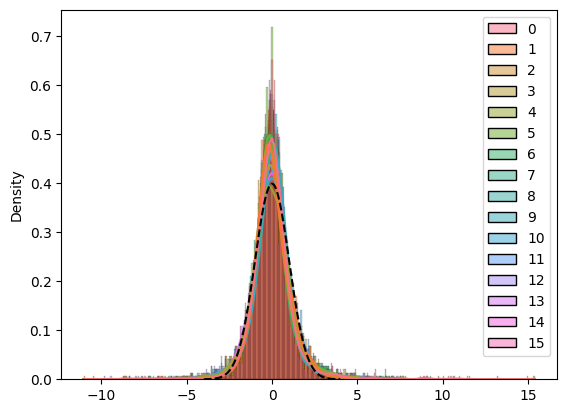

In [27]:
t = np.linspace(-4, 4, 1000)
sns.histplot(scores_u_test["MK Quantile"], kde=True, stat="density", common_norm=False)
plt.plot(t, norm.pdf(t), "k--")

<Axes: ylabel='Count'>

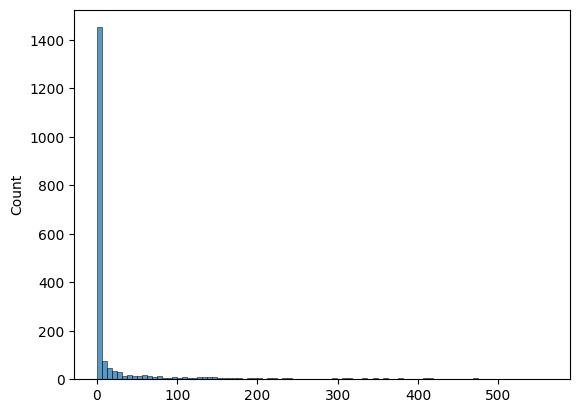

In [11]:
sns.histplot(np.exp(scores_u_test["Log Density"]))

In [12]:
q_method = QuantileEstimatePredictor(d_y=ds.n_outputs, seed=0, alpha=0.1)
pb_method = SplitConformalPredictor(d_y=ds.n_outputs, seed=0, alpha=0.1, lower_is_better=True)

In [13]:
q_method.fit(
    X_cal=ds.X_cal,
    scores_cal=scores_u_cal["MK Quantile"],
    alpha=0.1,
)

pb_method.fit(
    X_cal=ds.X_cal,
    scores_cal=scores_u_cal["MK Rank"],
    alpha=0.1,
)


SplitConformalPredictor(d_y=2, seed=0, alpha=0.1, lower_is_better=True)

In [14]:
q_method.is_covered(ds.X_test, scores_u_test["MK Quantile"]).mean(), pb_method.is_covered(ds.X_test, scores_u_test["MK Rank"]).mean()

(np.float64(0.85925), np.float64(0.8925))

In [15]:
pb_method.threshold, scores_u_test["MK Rank"].min(), scores_u_test["MK Rank"].max()

(np.float32(6.80801), np.float32(0.043570913), np.float32(33686.516))

In [18]:
# Calculate areas with smapling
n_samples = 10_000

rng = np.random.default_rng(args.seed)
ymin = ds.Y_train.min(axis=0)
ymax = ds.Y_train.max(axis=0)

scale = np.prod(ymax - ymin)
print(f"Bounding box volume: {scale}")

i = 101
X_samples = np.repeat(ds.X_test[i:i + 1], repeats=n_samples, axis=0)
Y_smaples = ymin + rng.random((n_samples, ds.n_outputs)) * (ymax - ymin)

scores_smaples = model_u.calculate_scores(X_samples, Y_smaples)
volume_i = np.mean(pb_method.is_covered(X_samples, scores_smaples["MK Rank"])) * scale
print(f"Volume estimate (sampling): {volume_i}, {np.log(volume_i) / ds.n_outputs}")

Bounding box volume: 127.45865302591433


Volume estimate (sampling): 42.1123389597621, 1.8701703923384838


In [ ]:
log_volumes = []
for _ in range(200):
    log_volumes.append(
        model_u.model.get_log_volume(
            torch.tensor(ds.X_test[i], dtype=torch.float32),
            pb_method.threshold,
            number_of_points_to_estimate_bounding_box=100,
            number_of_points_to_estimate_volume=10000,
        )
    )
    mean, std = torch.tensor(log_volumes).mean().item(), torch.tensor(log_volumes).std().item()
    print(f"{mean=}, {std=}")



log_v = model_u.model.get_log_volume(torch.tensor(ds.X_test[i], dtype=torch.float32), pb_method.threshold)

In [ ]:
from tqdm import trange
test_log_volumes, cal_log_volumes = [], []

test_progress_bar = trange(ds.X_test.shape[0])
for x_index in test_progress_bar:
    x = ds.X_test[x_index]
    test_log_volumes.append(
        model_u.model.get_log_volume(
            torch.tensor(x, dtype=torch.float32),
            pb_method.threshold
        )
    )
    mean, std = torch.tensor(test_log_volumes).mean().item(), torch.tensor(test_log_volumes).std().item()
    test_progress_bar.set_postfix({
        "index":x_index,
        "mean":mean,
        "std":std,
    })

calibration_progress_bar = trange(ds.X_cal.shape[0])
for x_index in calibration_progress_bar:
    x = ds.X_test[x_index]
    test_log_volumes.append(
        model_u.model.get_log_volume(
            torch.tensor(x, dtype=torch.float32),
            pb_method.threshold
        )
    )
    mean, std = torch.tensor(cal_log_volumes).mean().item(), torch.tensor(cal_log_volumes).std().item()
    calibration_progress_bar.set_postfix({
        "index":x_index,
        "mean":mean,
        "std":std,
    })

  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_1809619/3926412333.py:13: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  mean, std = torch.tensor(test_log_volumes).mean().item(), torch.tensor(test_log_volumes).std().item()
  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_1809619/3926412333.py:29: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  mean, std = torch.tensor(cal_log_volumes).mean().item(), torch.tensor(cal_log_volumes).std().item()
 22%|██▎       | 450/2000 [06:45<20:59,  1.23it/s, index=449, mean=nan, std=nan]  

In [42]:
ds.X_cal

array([[-1.14022129, -1.13987926,  0.8257349 , ..., -1.00024414,
         1.00016836, -1.00012627],
       [-0.38679415, -1.51662651,  0.8257349 , ...,  0.99975592,
        -0.99983166,  0.99987375],
       [-1.14022129, -1.13987926, -1.21104243, ...,  0.99975592,
        -0.99983166, -1.00012627],
       ...,
       [ 1.12006014, -0.38638475, -1.21104243, ...,  0.99975592,
         1.00016836, -1.00012627],
       [-0.38679415, -1.13987926,  0.8257349 , ...,  0.99975592,
        -0.99983166,  0.99987375],
       [-0.38679415, -1.13987926,  0.8257349 , ...,  0.99975592,
        -0.99983166,  0.99987375]], shape=(2000, 14))